# Manipulations sur le pré-traitement des données EEG

L'objectif de ce cahier est d'expérimenter sur le pré-traitement effectué sur les données EEG fournies.

Nous importons tout d'abord le module MNE pour manipuler les données.
Nous importons également le module matplotlib.pyplot pour les affichages.

In [1]:
import mne
import matplotlib.pyplot as plt

Nous lisons ensuite les données brutes et celles pré-traitées (ici S10_NF1).

In [2]:
raw = mne.io.read_raw_brainvision('../EEG_Data/raw/S10_NF1.vhdr')
pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')

Extracting parameters from ../EEG_Data/raw/S10_NF1.vhdr...
Setting channel info structure...
Extracting parameters from ../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr...
Setting channel info structure...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}


<ipython-input-2-f44402bd3d6d>:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')
<ipython-input-2-f44402bd3d6d>:2: DeprecationWarning: The `montage` parameter from `read_raw_brainvision` is deprecated and will be removed  in version 0.20. Use  raw.set_montage(montage) instead.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')


Les avertissements ci-dessus ne sont pas inquiétants. 

Nous affichons cependant les informations afin de s'assurer que tout est normal.

In [3]:
print(raw.info)
print(pp.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

On note tout d'abord une forte diminution de la fréquence d'échantillonage, ce qui permet d'effacer une partie du bruit. On note également l'ajout d'un champ 'dig' dans les données pré-traitées.

On en extrait les données, que l'on affiche pour s'assurer que tout fonctionne bien.

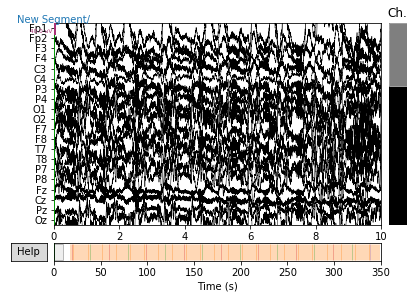

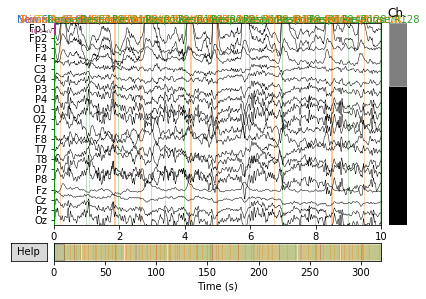

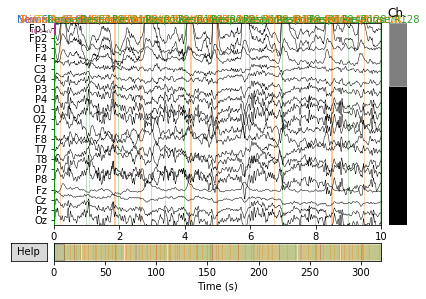

In [4]:
#time_interval = [20,50]
#raw_start_time, raw_stop_time = raw.time_as_index(time_interval)
#pp_start_time, pp_stop_time = pp.time_as_index(time_interval)

raw_data, raw_time = raw[:, :]
pp_data, pp_time = pp[:, :]

raw.plot()
pp.plot()

Nous nous intéresserons par la suite à la première électrode, étiquetée "Ep1".

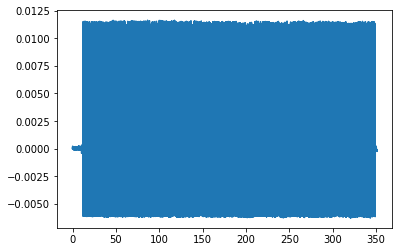

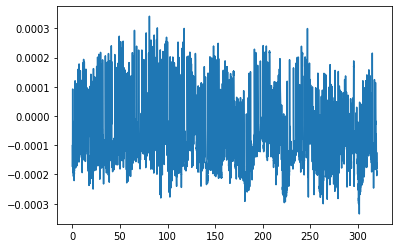

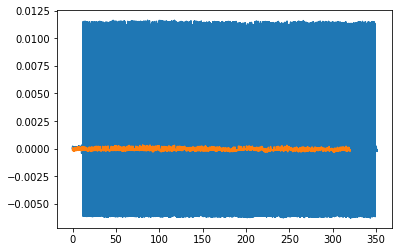

In [5]:
ep1_raw_data = raw_data[1,:]
ep1_pp_data = pp_data[1,:]

plt.plot(raw_time,ep1_raw_data)
plt.show()
plt.plot(pp_time, ep1_pp_data)
plt.show()

plt.plot(raw_time,ep1_raw_data)
plt.plot(pp_time, ep1_pp_data)
plt.show()

## Passage des données brutes aux pré-traitées

Nous allons ici retracer les étapes du pré-traitement tel que décrit dans le fichier "readme.rtf".

### Correction automatique de gradient

La première étape est de corriger l'artéfact de gradient, lié aux légères variations dans les gradients du champ magnétique de l'IRM, à une désynchronisation de l'EEG et de l'IRM, et à de léger mouvements de la tête.

Cela se fait à l'aide des marqueurs 'Response' du fichier .vmrk.

In [6]:
annotations = mne.read_annotations('../EEG_Data/raw/S10_NF1.vmrk')
response_annotations = [annotation for annotation in annotations if annotation['description'] == "Response/R128"]
print(len(response_annotations))

Finding 'sfreq' from header file: ../EEG_Data/raw/S10_NF1.vhdr
332


Ces marqueurs sont tous situés sur une trame unique (0.2 ms à 5kHz).

In [7]:
artifact_duration = response_annotations[0]['duration']
print(artifact_duration)

0.0002


In [8]:
for annotation in response_annotations:
    assert(annotation['duration'] == artifact_duration)

Vérifions si la position de ces marqueurs est périodique.

In [9]:
marker_period = response_annotations[1]['onset'] - response_annotations[0]['onset']

for i in range(len(response_annotations) - 1):
    if(response_annotations[i+1]['onset']-response_annotations[i]['onset'] != marker_period):
        print(response_annotations[i+1]['onset']-response_annotations[i]['onset'] - marker_period)

7.105427357601002e-15


Avec une fréquence d'échantillonnage à 5000 Hz, cette variation est négligeable (moins d'une trame). Nous allons donc considérer l'artéfact de gradient typique comme un "signal moyen" de ceux pris entre deux marqueurs.

Cela revient à faire l'hypothèse que le signal d'intérêt est de moyenne nulle (ou négligeable).

Nous allons dans un premier temps simplement retrancher au signal la moyenne glissante sur 21 intervalles de marqueurs. Nous allons utiliser la méthode cumsum du module np (https://stackoverflow.com/questions/13728392/moving-average-or-running-mean). 

In [24]:
import numpy as np

def cumsum_sma(array, period):
    ret = np.cumsum(array, dtype=float)
    ret[period:] = ret[period:] - ret[:-period]
    return ret[period - 1:] / period

def cumulative_interval_average(array, window_size, interval_size):
    averaged_array = []
    for i in range(window_size, len(array)):
        averaged_array.append(np.mean(array[i-window_size:i+1:interval_size]))
    return np.array(averaged_array)

sma_window_time_size = 42*marker_period
sma_window_frame_size = raw.time_as_index([0, sma_window_time_size])[1]
interval_size = raw.time_as_index([0, marker_period])[1]

print(interval_size)

#ep1_raw_averaged_raw_data = cumsum_sma(ep1_raw_data, sma_window_frame_size)
ep1_raw_averaged_raw_data = cumulative_interval_average(ep1_raw_data, sma_window_frame_size, interval_size)

5000


Nous complétons les bords par des 0 pour retrouver une taille normale.

In [33]:
print(ep1_raw_averaged_raw_data.shape)
print(ep1_raw_data.shape)

#size_diff = len(ep1_raw_data) - len(ep1_raw_averaged_raw_data)
v1_time = raw_time[sma_window_frame_size:]
#ep1_averaged_raw_data = np.concatenate([[0]*(size_diff//2), [0], ep1_raw_averaged_raw_data, [0]*(size_diff//2)])
ep1_averaged_raw_data = ep1_raw_averaged_raw_data

assert(ep1_averaged_raw_data.shape == v1_time.shape)


(1544500,)
(1754500,)


Nous faisons enfin la soustraction point par point.

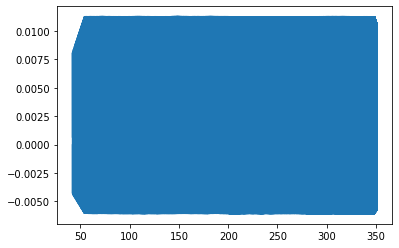

In [34]:
ep1_v1_pp_data = ep1_raw_data[sma_window_frame_size:] - ep1_averaged_raw_data

#plt.plot(raw_time, ep1_v1_pp_data)
plt.plot(v1_time, ep1_averaged_raw_data)
plt.show()

[242.     242.0002 242.0004 ... 261.9994 261.9996 261.9998]


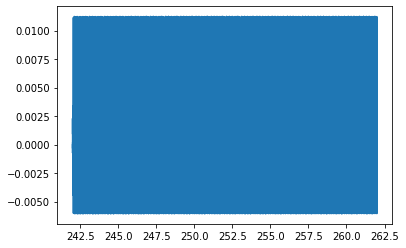

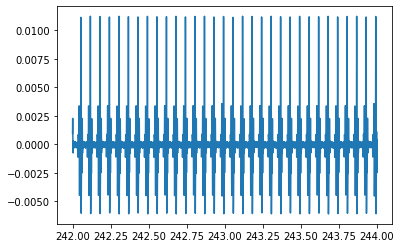

In [35]:
print(v1_time[1000000:1100000])
plt.plot(v1_time[1000000:1100000], ep1_averaged_raw_data[1000000:1100000])
plt.show()
plt.plot(v1_time[1000000:1010000], ep1_averaged_raw_data[1000000:1010000])#2sec

## Sous-échantillonnage

Nous pouvons ensuite faire un sous-échantillonnage du signal, à 200 Hz, à l'aide de la méthode resample du module scipy.signal.

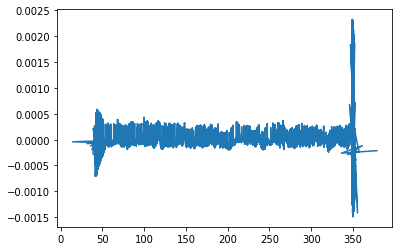

In [36]:
from scipy import signal

samples_amount = len(ep1_v1_pp_data)//25
ep1_v2_pp_data = signal.resample(ep1_v1_pp_data, samples_amount)
resampled_time = signal.resample(v1_time, samples_amount)

plt.plot(resampled_time, ep1_v2_pp_data)
plt.show()

## Filtre passe-bas

Nous appliquons ensuite un filtre passe-bas à réponse impulsionnelle finie de 50 Hz, les fréquences supérieures étant considérées comme du bruit.

In [21]:
sample_rate = 200

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 50

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
ep1_v3_pp_data = signal.lfilter(taps, 1.0, ep1_v2_pp_data)

Nous affichons ensuite le signal obtenu, ici en orange, comparé au signal précédent, en bleu.

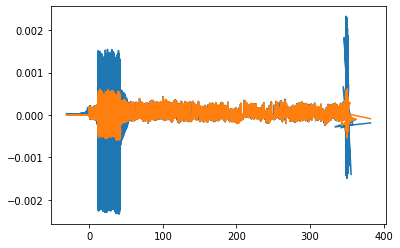

In [22]:
plt.plot(resampled_time, ep1_v2_pp_data)
plt.plot(resampled_time, ep1_v3_pp_data)
plt.show()

# ANCIENS ESSAIS

Cela vérifié, nous pouvons moyenner point par point.

**NOTA BENE : à refaire avec une moyenne glissante**

In [ ]:
artifacts_signals = np.array([ep1_raw_data[
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[0]:
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[1]
    
                                          ] 
                              for annotation in response_annotations])

mean_artifact_signal = np.mean(artifacts_signals, axis = 0)
time_reference = np.arange(0, len(mean_artifact_signal))/len(mean_artifact_signal)*artifact_duration

plt.plot(time_reference, mean_artifact_signal)
plt.show()

print(mean_artifact_signal.shape,ep1_raw_data.shape)
print(artifacts_signals[0].shape)

Nous pouvons ensuite soustraire cette forme au signal original au niveau des artéfacts.

In [ ]:
for annotation in response_annotations:
    artifact_time_interval = ([annotation['onset'], 
                               annotation['onset']+annotation['duration']])
    artifact_start_frame, artifact_end_frame = raw.time_as_index(artifact_time_interval)
    
    
    print(artifact_time_interval)
    print(artifact_start_frame, artifact_end_frame)
    print(ep1_raw_data[ artifact_start_frame : artifact_end_frame ])
    ep1_raw_data[ artifact_start_frame : artifact_end_frame ]-= mean_artifact_signal